In [1]:
from opt.mc_sim import *
import time
from common.variables import *

In [2]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
# filename = "output/msource_value_dic_06-22-2022-03-55-05.pkl"
# filename = "output/msource_value_dic_06-22-2022-20-55-01.pkl"
filename = "output/msource_value_dic_06-25-2022-07-31-29.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

In [3]:
sourcingEnv2 = SourcingEnv(
        lambda_arrival = LAMBDA, # or 10
        procurement_cost_vec = np.array([1, 3]),
        supplier_lead_times_vec = np.array([0.8, 0.5]),
        on_times = np.array([1, 1]), 
        off_times = np.array([np.Inf, np.Inf]))

In [4]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 50,
  'nested_mc_iters': 50,
  'mc_episodes': 50,
  'max_steps': 50,
  'explore_eps': 0.05,
  'debug_bool': 0,
  'fixed_learn_rate': 0.1},
 'policy_params': {'h_cost': 3,
  'b_penalty': 5,
  'small_s': 1,
  'big_s': 6,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0},
 'eval_params': {'safe_factor': 1.1,
  'n_visit_limit': 2,
  'sub_eval_periods': 30,
  'sub_nested_mc_iter': 30},
 'git_commit': 'no_git',
 'branch_name': 'no_git'}

In [5]:
# best_small_s, best_big_s, best_val = find_opt_ss_policy_via_mc(sourcingEnv, periods = 20, nested_mc_iters = 50)
# best (s, S) policy found by MC:: (2, 5)

In [6]:
# model_params['branch_name'], model_params['git_commit']

In [7]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
# sourcingEnv = SourcingEnv(
#         lambda_arrival = LAMBDA, # or 10
#         procurement_cost_vec = np.array([3, 1]),
#         supplier_lead_times_vec = np.array([0.8, 0.5]),
#         on_times = np.array([1, 1]), 
#         off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 100,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

# print(mc_avg_costs)

100%|██████████| 100/100 [00:01<00:00, 91.28it/s]


In [8]:
# mc_avg_costs = mc_with_ss_policy(sourcingEnv, 
#     periods = 100,
#     nested_mc_iters = 50,
#     big_s = 5,
#     small_s = 2,
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'])

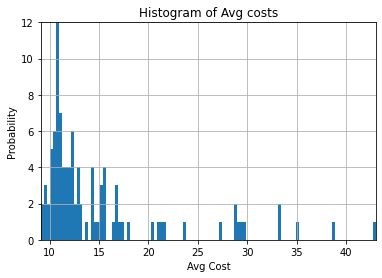

In [9]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [10]:
print(np.mean(np.array(mc_avg_costs)))

14.988


In [11]:
print(np.median(np.array(mc_avg_costs)))

12.233333333333333


In [12]:
np.std(np.array(mc_avg_costs))

6.930267783827371

In [13]:
mc_avg_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 50,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy,
    use_tqdm = True)

  0%|          | 0/50 [00:00<?, ?it/s]/home/larkin/code/multi-sourcing-inventory/sim/policies.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  overshoot_range = np.array([x for x in sourcingEnv.action_history_tuple if tmark_reg < x[0] < tmark_exp])
100%|██████████| 50/50 [06:07<00:00,  7.36s/it]


In [14]:
print(np.mean(np.array(mc_avg_costs)))

43.345333333333336


In [15]:
print(np.median(np.array(mc_avg_costs)))

33.35


In [16]:
np.std(np.array(mc_avg_costs))

26.755633060057544

In [17]:
eval_steps = 5
mc_eval_iter = 5
eval_costs = mc_eval_policy_perf(sourcingEnv, value_dic, 
    max_steps = eval_steps, 
    mc_iters = mc_eval_iter,
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'])

avg_eval_cost = np.mean(eval_costs)

 20%|██        | 1/5 [01:25<05:41, 85.29s/it]

In [ ]:
eval_costs_scaled = np.array(eval_costs)/eval_steps

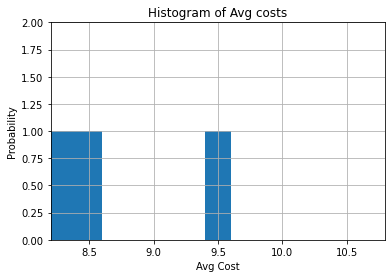

In [ ]:
import numpy as np

binwidth = 0.2

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [ ]:
np.mean(eval_costs_scaled)

9.52

In [ ]:
np.median(eval_costs_scaled)

9.4

In [ ]:
np.std(eval_costs_scaled)

1.1214276615100953

In [ ]:
len(list(value_dic.keys()))

72568

-7.6096

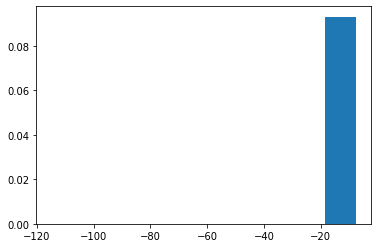

In [ ]:
import numpy as np

binwidth = 0.3

state_vals = [x[0] for x in list(value_dic.values())]
state_visits = [x[1] for x in list(value_dic.values())]

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

99

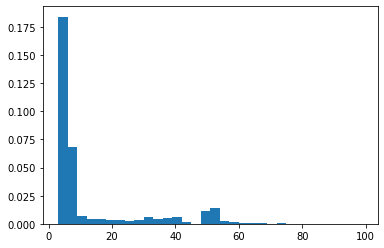

In [ ]:
binwidth = 3
state_visits.remove(1)
state_visits_massage = [x for x in state_visits if 100 > x > 2]

n, bins, patches = plt.hist(state_visits_massage, bins=np.arange(min(state_visits_massage), max(state_visits_massage) + binwidth, binwidth), density = True)
np.max(state_visits_massage)

In [ ]:
np.min(state_visits_massage)

3

In [ ]:
len(set(state_visits))

102

In [ ]:
len(state_visits_massage) - len(state_visits)

-42983

In [ ]:
len(state_visits)

72567

In [ ]:
len(state_vals)

72568

In [ ]:

max(value_dic, key=value_dic.get)


'[9, 5, 40, 1, 1]'

In [ ]:
min(value_dic, key=value_dic.get)

'[29, 0, 0, 1, 1]'

In [ ]:
value_dic_key_sorted = sorted(value_dic, key=value_dic.get, reverse=True)
value_dic_value_sorted = sorted(value_dic.values(), reverse=True)

In [ ]:
value_diagnostic = list(zip(value_dic_key_sorted, value_dic_value_sorted))

In [ ]:
value_diagnostic

[('[9, 5, 40, 1, 1]', (-7.6096, 1)),
 ('[23, 26, 40, 1, 1]', (-7.8012, 3)),
 ('[1, 54, 44, 1, 0]', (-7.8244, 1)),
 ('[-1, 28, 39, 1, 0]', (-7.839999999999999, 7)),
 ('[23, 15, 10, 1, 1]', (-7.848799999999999, 1)),
 ('[5, 22, 51, 0, 1]', (-7.8512, 1)),
 ('[4, 27, 34, 1, 1]', (-7.858, 1)),
 ('[1, 0, 43, 1, 1]', (-7.863199999999999, 1)),
 ('[0, 45, 44, 1, 1]', (-7.8664, 1)),
 ('[29, 53, 24, 1, 1]', (-7.8675999999999995, 4)),
 ('[41, 36, 13, 1, 1]', (-7.8708, 1)),
 ('[17, 27, 23, 0, 1]', (-7.873999999999999, 1)),
 ('[-1, 4, 25, 1, 1]', (-7.880799999999999, 53)),
 ('[17, 24, 33, 1, 1]', (-7.8824000000000005, 3)),
 ('[21, 15, 57, 1, 1]', (-7.8828, 2)),
 ('[1, 29, 31, 1, 1]', (-7.8831999999999995, 1)),
 ('[1, 46, 44, 1, 0]', (-7.8844, 1)),
 ('[1, 53, 28, 0, 1]', (-7.8912, 1)),
 ('[16, 20, 39, 1, 1]', (-7.8912, 1)),
 ('[19, 1, 49, 1, 1]', (-7.8924, 2)),
 ('[22, 8, 45, 1, 1]', (-7.893199999999999, 4)),
 ('[3, 5, 22, 1, 1]', (-7.895199999999999, 1)),
 ('[18, 11, 1, 1, 1]', (-7.8952, 1)),
 ('[28,

In [ ]:
with open('output/diagnostic_output.txt', 'w') as f:
    for item in value_diagnostic:
        f.write("{i}\n".format(i = str(item)) )

In [ ]:
item

('[29, 0, 0, 1, 1]', (-114.81457733355218, 36))

In [ ]:
len(value_dic)

72568